In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.spatial.distance import cosine
from scipy.cluster.vq import vq,kmeans,whiten
import time
%matplotlib inline



In [2]:
#functions 
#input: product ID
#output: sparse vector based on vectorizer

def to_vector(product_id):
    temp = reviews[reviews.ProductId == product_id]
    text = list(temp['Text'].values + ' ' + temp['Summary'].values)
    new_string = np.array([''.join(text)]).reshape(1,)
    return vectorizer.transform(new_string).toarray()

def to_words(product_id):
    temp = reviews[reviews.ProductId == product_id]
    text = list(temp['Text'].astype(str).values + ' ' + temp['Summary'].astype(str).values)
    return np.array([''.join(text)]).reshape(1,)



Get Unique products and users

In [3]:
reviews = pd.read_csv('Reviews.csv')
unique_users = reviews.UserId.unique()
unique_products = reviews.ProductId.unique()

In [4]:
#whole thing takes a long time(>30minutes), use first 1000 products
start = time.time()
unique_prod_reviews = map(lambda x: to_words(x),unique_products[0:1000])
end = time.time()
print end - start

29.4949069023


In [5]:
#Show the first 5 entries of the product DF
product_df = pd.DataFrame()
product_df['ProductId'] = unique_products[0:1000]
product_df['Text'] = unique_prod_reviews
product_df.head()

,ProductId,Text
0,B001E4KFG0,[I have bought several of the Vitality canned ...
1,B00813GRG4,[Product arrived labeled as Jumbo Salted Peanu...
2,B000LQOCH0,[This is a confection that has been around a f...
3,B000UA0QIQ,[If you are looking for the secret ingredient ...
4,B006K2ZZ7K,[Great taffy at a great price. There was a wi...


In [6]:
a = np.array(unique_prod_reviews)
a = a.reshape(len(a),)
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(a)

In [7]:
tfidf_matrix.toarray()
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_similarities

array([[  1.00000000e+00,   5.36110174e-03,   0.00000000e+00, ...,
          8.28603989e-03,   5.19533133e-03,   5.02833995e-03],
       [  5.36110174e-03,   1.00000000e+00,   0.00000000e+00, ...,
          5.29899866e-03,   0.00000000e+00,   1.78627910e-03],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  8.28603989e-03,   5.29899866e-03,   0.00000000e+00, ...,
          1.00000000e+00,   8.30201976e-03,   7.89411311e-04],
       [  5.19533133e-03,   0.00000000e+00,   0.00000000e+00, ...,
          8.30201976e-03,   1.00000000e+00,   4.70532436e-03],
       [  5.02833995e-03,   1.78627910e-03,   0.00000000e+00, ...,
          7.89411311e-04,   4.70532436e-03,   1.00000000e+00]])

In [8]:
#takes a product name in the unique products data and returns the 8 most similar products
#input: Product ID, Product Dataframe, Similarity Matrix
#output: Array of 8 nearest items in the database using cosine similarity

def return_nearest(product,cosine_similarities,product_df):
    idx = product_df[product_df.ProductId == product].index[0]
    similar_indices = cosine_similarities[idx].argsort()[:-10:-1]
    similar_items = [(cosine_similarities[idx][i], product_df['ProductId'][i]) for i in similar_indices]
    return similar_items[1:]

In [9]:
return_nearest('B00813GRG4',cosine_similarities,product_df)

[(0.060071873611170931, 'B000CMFMG8'),
 (0.052140838382313696, 'B0047LRBX2'),
 (0.043432096349825311, 'B001EO6BCC'),
 (0.037325003722012799, 'B000G6RPMY'),
 (0.026276191344016604, 'B001FA1L7U'),
 (0.025318462964514555, 'B004AVYUOW'),
 (0.025057186536542934, 'B001HOUGFC'),
 (0.023818763987623219, 'B000YT5DBS')]

In [10]:
def number_reviews(users):
    number_reviews_ = []
    for user in users:
        number_reviews_.append(reviews[reviews['UserId'] == user].values.shape[0])
    return np.array(number_reviews_)
        
start = time.time()    
number_reviews_1000 = number_reviews(unique_users[0:1000])
end = time.time()

In [11]:
#lets consolidate everything we're working with
u_users = unique_users[0:1000]
print number_reviews_1000

[  1   1   3   3   2   1   2   1   2   4   4  12   2  20 201   1   2   1
  49   2   1   2   2   4   2   3   2   1   1   1   2  17   4   1   4   3
   1   2   6  10   1   1   6  88  12 133   1  14   3   2   2   9   2   2
   2   1   1   1   3   1   1   1   1   1   1   1   2   2   3   5   1   3
  21   1   4  13  16   1  17   1   1   3   2   4   1   1   2   1   1   1
   1   1   2   1   1   9   1   1   1  12   8  18   8  11   7   7   2   4
 389   2   4   4   4   4   4   1   1   8   5   5   4   4   9   4   6   4
   1  10   1   1   1   3   3  15   3  10   1   1   1   1  75   6 256  27
   1   1   1   2   4   2   1   1   1   5   1   5   3  47   4   1   1   1
  15   1   4   1   1   3   3   3   1   2   1   2   9   7  33  23   1  22
   1   7   1   3   1 140   1   1   1   1  49   1   3   8   1   2   1   1
   2   1   3   1   1   1   1   1   1   9   1   1  10   2   8   1   1   3
  59   1   2   1   3   2   1   2   9   1   1   1   1   1  99   1   1   4
   8   1   6  42  10   1   2   1   1   2   5   1   

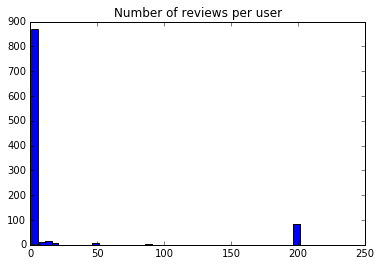

In [385]:
plt.figure()
plt.title('Number of reviews per user')
plt.hist(number_reviews_1000[number_reviews_1000],bins =40)
plt.show()

We see that there is a large population of user that write a large number of reviews. For our recommender system we can focus on the subset of the population that writes greater than $N$ reviews, so that there is more data upon which to base a recommender model. 

### Constructing a Rating Matrix
- Define 0 to be unrated
- 1 through 5 as usual

We will focus on our subset of 1000 users but look at all products

In [12]:
len(unique_products)

74258

In [13]:
len(unique_users)

256059

In [14]:
reviews[reviews['UserId']==u_users[100]][['ProductId','Score']].values

array([['B004K2IHUO', 4],
       ['B006L4FNB0', 4],
       ['B00115FPV2', 5],
       ['B009AVD282', 4],
       ['B002Y1CVZU', 4],
       ['B00815FR68', 4],
       ['B000PKMN14', 4],
       ['B006L4FMR0', 4]], dtype=object)

In [15]:
def construct_rating_matrix(u_users,unique_products):
    r_matrix = np.zeros((len(u_users),len(unique_products)))
    for i in range(len(u_users)):
        user = u_users[i]
        products = reviews[reviews['UserId']== user][['ProductId','Score']].values
        for j in range(len(products)):
            product = products[j][0]
            stars = products[j][1]
            index = np.argwhere(unique_products == product)[0][0]
            r_matrix[i,index] = stars
    return r_matrix 
            
rating_matrix = construct_rating_matrix(u_users,unique_products)        

### Construct User Similarity Matrix

In [16]:
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise_distances

#rating matrix to user similarity matrix 
def user_similarity_matrix(rating_matrix):
    return 1 - pairwise_distances(rating_matrix, metric="cosine")
    


Generating predictions for a user $u$ requires using $s: U \times U \to R$, similarity function, to compute a neighborhood $ N \subseteq U$ of neighbors of $U$

#### Possible User/Product Similarity Functions:
- Pearson Correlation: compute the statistical correlation between two vectors. This is the correlation as it is usually defined, sample covariance divided by the standard deviations.

- Cosine similarity: similarity is measured as the cosine distance between two rating vectors. 
$$ \frac{r_{u} \cdot r_{v}}{||r_{u}|||r_{v}||}$$

- Consider possibilities of other scoring methods 

#### Other Considerations: 
- Subtraction off the mean of each user to account for differences in users' use of the rating scale
- Tuning parameter: number of group neighbors to select

First let's take users that have 10 or more ratings. We can tune this parameter later. Looking at the first 10000 users:...

In [18]:
number_reviews_10000 = number_reviews(unique_users[0:10000])   

In [19]:
u_users2 = unique_users[0:10000]

In [22]:
u_users2[number_reviews_10000>10].shape

(1535,)

Above we find that 1535 of the first 10000 users rated 10 items or more

In [23]:
#users who rated 10 or more
users10 = u_users2[number_reviews_10000>10]

#Construct rating matrix
rating_matrix = construct_rating_matrix(users10,unique_products)

In [24]:
user_matrix = user_similarity_matrix(rating_matrix)


In [25]:
user_matrix

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.0720166 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.0720166 ,  1.        , ...,  0.01864802,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.01864802, ...,  1.        ,
         0.19083678,  0.17568633],
       [ 0.        ,  0.        ,  0.        , ...,  0.19083678,
         1.        ,  0.12258461],
       [ 0.        ,  0.        ,  0.        , ...,  0.17568633,
         0.12258461,  1.        ]])

We define the neighborhood $N \subseteq U$ as the set of nearest neighbors to $u$ of size $N$

In [31]:
def return_nearest_users(user,cosine_similarities,users,N):
    idx = np.argwhere(users == user)[0][0]
    similar_indices = cosine_similarities[idx].argsort()[:-N-2:-1]
    similar_users = [(cosine_similarities[idx][i], users[i],i) for i in similar_indices]
    return similar_users[1:]

In [32]:
#test, gets the neighborhood of a user

return_nearest_users('A2HL2BY512HTVQ',user_matrix,users10,8)

[(0.58140189973381107, 'A2725IB4YY9JEB', 0),
 (0.33921895875554398, 'A3SEW1ECTN5D0D', 592),
 (0.28997691150759519, 'A1CVQY61GRH0D5', 615),
 (0.27849211508082061, 'AJF5B70OO7S43', 593),
 (0.27198024059173842, 'A38AK9ROCL1UN6', 627),
 (0.26916754617306071, 'A221IYGUANAAL2', 617),
 (0.26916754617306071, 'A1YCWZWOXLUAY5', 614),
 (0.26676548700234215, 'A2BLJGGWN8GTXQ', 62)]

In [36]:
neighborhood = return_nearest_users('A2HL2BY512HTVQ',user_matrix,users10,8)

## Top 5 Suggestions (User-User Collaborative Filtering):
We make predictions according to:

$$p_{u,i} = \bar r_u + \frac{\sum{s(u,u')(r_{u',i} - \bar r_{u'})}}{\sum |s(u,u')|} $$

Where the summation runs over all users in $N$. 

$\bar r_{u'}$ is defined as the mean rating for user $u'$

In [192]:
#input: number of items to suggest N, neighborhood as defined above
#we are assuming that the user is in the 
def suggest_items(user, N, neighborhood,users,rating_matrix):
    
    #mean rating for the user
    idx = np.argwhere(users == user)[0][0]
    mean_rating = rating_matrix[idx][rating_matrix[idx]!=0].mean()
    
    #from the neighborhood we get the simiarilities, the indices, and the usernames
    indices = [i[2] for i in neighborhood]
    similarities = np.array([i[0] for i in neighborhood])
    usernames = [i[1] for i in neighborhood]
    
    #we'll only look at the ratings that are in the neighborhood
    ratings = rating_matrix[indices]
    
    #adding user means to an array
    user_means = []
    for i in range(len(ratings)):
        user_means.append(ratings[i,:][ratings[i,:]!=0].mean())
    
    #put these user means in an array of the correct size and shape
    user_means = np.array([user_means]*ratings.shape[1]).T
    
    #new array for adjusted ratings, same size as ratings
    adjust_ratings = np.zeros((ratings.shape[0],ratings.shape[1]))
    adjust_ratings[ratings > 0] = ratings[ratings> 0] - user_means[ratings>0]
    
    #weight by similarity
    adjusted_ratings = similarities.reshape(len(similarities),1) * adjust_ratings
    unnormalized_predictions = np.sum(adjusted_ratings,axis=0)
    
    #following the formula above
    predictions = unnormalized_predictions/(sum(similarities)) + mean_rating
    
    #return the best rated items
    predicted_indices = predictions.argsort()[:-N-1:-1]
    final_prediction = [(predictions[i], i) for i in predicted_indices]
    return final_prediction


In [194]:
predictions = suggest_items('A2HL2BY512HTVQ', 10, neighborhood, users10, rating_matrix)
predictions

[(3.4965541613799926, 539),
 (3.4965541613799926, 31062),
 (3.4965541613799926, 74173),
 (3.4965541613799926, 55576),
 (3.4965541613799926, 44669),
 (3.1490603247306308, 63921),
 (3.1490603247306308, 60237),
 (3.109585031680199, 67063),
 (3.0393201408593873, 65735),
 (3.0393201408593873, 29898)]

In [196]:
print 'Suggested Products:'
print 

for i,j in predictions:
    print unique_products[j]
    

Suggested Products:

B005K4Q1VI
B005K4Q4KG
B005K4Q68Q
B005K4Q1T0
B0076MLL12
B0013A0QXC
B000UBD88A
B004LLAYA0
B001E4S8GO
B000XZFZI4


### How do we evaluate recommender systems?
 
- We want to look at users that write a lot of reviews, so that we can validate our model's predictions by dividing their reviews into two parts
- Training/Test set: We build the recommender system upon the training set. For the users in the test set we divide into **query set** and **target set**. 
- The **query set** is fed into the recommender system and the function we want to maximize is the similarity score between the recommendations based on the query set and the **target set**


- Alternatively, our cost function can simply be the difference between predicted rating based on neighbors and our current rating

Goal: write a reasonable score function. Our first score function will be based on the above and we will use our item similarity metric from content based filtering as our distance metric for target v. test


**Two types of item similarity**:

- Distance between user vectors
- Distance between bag of word histograms <-- use this for this part

In [213]:
#begin by dividing our rating matrix into train and test
rand_perm = np.random.permutation(len(users10))
train = rand_perm[:len(rand_perm)/2]
test = rand_perm[len(rand_perm)/2:]

#build our content based recommender off of the training set
train_users = users10[train]
test_users = users10[test]

#divide the test users into query and target
def query_and_target(test_users,unique_products):
    
    r_matrix = np.zeros((len(test_users),len(unique_products)))
    target_sets =[]
    
    for i in range(len(test_users)):
        user = test_users[i]
        products = reviews[reviews['UserId']== user][['ProductId','Score']].values
        #query set goes into matrix form (half)
        
        target_set = []
        for j in range(len(products)/2):
            product = products[j][0]
            stars = products[j][1]
            index = np.argwhere(unique_products == product)[0][0]
            r_matrix[i,index] = stars
        
        #collect a list of target items and ratings (half)
        for j in range(len(products)/2,len(products)):
            product = products[j][0]
            stars =products[j][1]
            target_set.append((product,stars))
        target_sets.append(target_set)
    
    return r_matrix , target_sets

rating_matrix, target_sets = query_and_target(test_users,unique_products)



Need to rewrite the cosine similarities functions ....

In [218]:
training_rating_matrix = construct_rating_matrix(train_users,unique_products)

In [238]:
def cos_distance(test_item,training_rating_matrix):
    cos_distances =[]
    for i in range(len(training_rating_matrix)):
        cos_distances.append(1- cosine(test_item,training_rating_matrix[i]))
    return np.array(cos_distances)
    

In [246]:
def neighbors(cos_distances, n_neighbors,train_users):
    args = cos_distances.argsort()[:-n_neighbors-1:-1]
    list_of_users = [(cos_distances[i],train_users[i],i) for i in args]
    return list_of_users

In [247]:
cos_distances = cos_distance(rating_matrix[0],training_rating_matrix)
list_neighbors = neighbors(cos_distances,5,train_users)

**Here we list the 5 nearest neighbors in the training set of the first guy in the test set:**
- The index is their index in the training set

In [248]:
list_neighbors

[(0.43660667251700946, 'A1PMWT1I668I15', 397),
 (0.38830274910474849, 'A3T5NSG7LMRY0A', 703),
 (0.30100073218739798, 'A1RF9YK4BK5TRH', 31),
 (0.28223139320266732, 'A32GCOTGFJ9XC3', 463),
 (0.271696333500832, 'A1JFXOFDRZ9CFQ', 230)]

**Suggest 5 Products based on these neighbors**

In [364]:
def suggest_items(test_user,N, neighborhood,rating_matrix):
    
    mean_rating = test_user[test_user!=0].mean()
    
    #from the neighborhood we get the simiarilities, the indices, and the usernames
    indices = [i[2] for i in neighborhood]
    similarities = np.array([i[0] for i in neighborhood])
    usernames = [i[1] for i in neighborhood]
    
    #we'll only look at the ratings that are in the neighborhood
    ratings = rating_matrix[indices]
    
    #adding user means to an array
    user_means = []
    for i in range(len(ratings)):
        user_means.append(ratings[i,:][ratings[i,:]!=0].mean())
    
    #put these user means in an array of the correct size and shape
    user_means = np.array([user_means]*ratings.shape[1]).T
    
    #new array for adjusted ratings, same size as ratings
    adjust_ratings = np.zeros((ratings.shape[0],ratings.shape[1]))
    adjust_ratings[ratings > 0] = ratings[ratings> 0] - user_means[ratings>0]
    
    #weight by similarity
    adjusted_ratings = similarities.reshape(len(similarities),1) * adjust_ratings
    unnormalized_predictions = np.sum(adjusted_ratings,axis=0)
    
    #following the formula above
    predictions = unnormalized_predictions/(sum(similarities)) + mean_rating
    predictions[test_user!=0] = 0 
    
    #return the best rated items
    predicted_indices = predictions.argsort()[:-N-1:-1]
    final_prediction = [(predictions[i], i) for i in predicted_indices]
    return final_prediction


#alternative method of suggesting items... 
def suggest_items2(user_mean_rating, N, neighborhood,rating_matrix):
    
    mean_rating = user_mean_rating
    #from the neighborhood we get the simiarilities, the indices, and the usernames
    indices = [i[2] for i in neighborhood]
    similarities = np.array([i[0] for i in neighborhood])
    usernames = [i[1] for i in neighborhood]
    
    #we'll only look at the ratings that are in the neighborhood
    ratings = rating_matrix[indices]
    
    #weight by similarity
    adjusted_ratings = similarities.reshape(len(similarities),1) * ratings
    unnormalized_predictions = np.sum(adjusted_ratings,axis=0)
    
    #following the formula above
    predictions = unnormalized_predictions/(sum(similarities))
    
    #return the best rated items
    predicted_indices = predictions.argsort()[:-N-1:-1]
    final_prediction = [(predictions[i], i) for i in predicted_indices]
    return final_prediction



In [365]:
pred = suggest_items(rating_matrix[0].mean(),5,list_neighbors,training_rating_matrix)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: DeprecationWarning: using a boolean instead of an integer will result in an error in the future


In [366]:
pred

[(0.12365252917518949, 58949),
 (0.12365252917518949, 24775),
 (0.12365252917518949, 5845),
 (0.12365252917518949, 55259),
 (0.12365252917518949, 49399)]

In [367]:
unique_products[56084]

'B001EQ5K9U'

In [390]:
#put this all into one function:

rand_perm = np.random.permutation(len(users10))
train = rand_perm[:len(rand_perm)/2]
test = rand_perm[len(rand_perm)/2:]

#build our content based recommender off of the training set
train_users = users10[train]
test_users = users10[test]

test_rating_matrix, target_sets = query_and_target(test_users,unique_products)
training_rating_matrix = construct_rating_matrix(train_users,unique_products)


# INPUT: index in the test rating matrix
# OUTPUT: predictions
def fn(i):
    cos_distances = cos_distance(test_rating_matrix[i],training_rating_matrix)
    list_neighbors = neighbors(cos_distances,20,train_users)
    pred = suggest_items(test_rating_matrix[i],5,list_neighbors,training_rating_matrix)
    return pred

In [370]:
for i in fn(388):
    print i[0]

5.0
5.0
5.0
5.0
5.0
5.0


In [371]:
# looking at first 10 test items

for i in range(10):
    print "TEST USER #: " +  str(i)
    print "TARGET SETS"
    for j in target_sets[i]:
        print j[1],j[0]
    
    print
    print "RECOMMENDATIONS"
    for k in fn(i):
        print k[0],unique_products[k[1]]
        
    if test_rating_matrix[i][test_rating_matrix[i]!=0].mean():
        
    print 


TEST USER #: 0
TARGET SETS
5 B000E8WIAS
4 B006ACQY8Y
5 B0014RK2F6
4 B005RGZO2G
4 B005HB4HHO
2 B003GADBDO
4 B0038NA3X0
4 B005HB4HH4
5 B004VLVOZO

RECOMMENDATIONS
4.44444444444
4.60504332251 B000ED9LDU
4.60191213147 B001E5E3IA
4.59637665323 B001E5E06K
4.59637665323 B000P4Y8E0
4.59637665323 B001Z7AEW6

TEST USER #: 1
TARGET SETS
5 B002CJO8T6
3 B000ORY230
5 B0018QIPS4
3 B00139ZPKM
5 B002E0S506
4 B001CBCJGE
5 B0018QNL3I
3 B000VK33C6
3 B001EO77FW
3 B001EO77FC
5 B0018QIQFG
5 B000LKX8YE

RECOMMENDATIONS
4.5
4.75932169044 B000KV7ZGQ
4.75932169044 B004R8FKO2
4.75932169044 B000FA38ZY
4.75932169044 B004FEN3GK
4.75932169044 B000KV61FC

TEST USER #: 2
TARGET SETS
2 B0047726E0
4 B004JJMWWM
5 B002GWME4A
5 B002RGU2G2
5 B0029JHN46
5 B0087FJ23Q
5 B003U95F9Y
5 B007RTR8A2
3 B005HG9ESG
5 B001EO5UZ6
5 B000UBH9YE
5 B000EM8TYS
5 B001M0A6C4
5 B0032GL19S
5 B0040J01L0
5 B000EM6PKI
2 B000HJ7AIY
5 B001VH91OW
5 B002LVACWM
5 B004UOA23M
5 B001E5E0NI
5 B000V17MLS
5 B002IEVJRY
5 B0041QCURU
1 B001UKBDGY
4 B000Q611U6
4 B0

**problem: if the second term is 0, recommendations are just the first ones**

Ways to deal with this:
- suggest highly rated products
- use suggest_items2
- larger neighborhood

**also it's possible to get nans if there are no similar users at all (really unlikely because this means that the user didn't rate any of the same items as anyone else)**

**fixed** another problem: it's possible to recommend products the user already reviewed. need to add a check

### Defining a Scoring Function
- Above, we printed recommendations alongside the actual target set. We'll consider ways of scoring how well these recommendations compare to the target set.
- First, we need a metric for product similarity. One way to do this is to look at product metadata (text and summaries)
- We fit TF-IDF Vectorizer above for the content based approach, so we can use that to vectorize our products here. We'll take cosine similarity of these vectors to get product similarity. 
- We should only consider things in the target set that are positively reviewed:

**Def. Similarity score between Recommendations and Target Set** 

$$ F(\phi,\lambda) = \frac{1}{|\phi||\lambda|} \sum_i \sum_j R(\lambda_j) s(\phi_i, \lambda_j) $$

where $\lambda$ is the set of recommendations and $\phi$ is the positively review (>3.5) target set. We weight by the rating in the target set (either 4 or 5). 

This scoring function is not necessarily the best metric for a company to use to evaluate a recommender since it rewards guessing products that are similar to what the customer actually bought. Suggesting these products will help facilitate the user finding these products but may not generate much revenue that the company would not have received anyways. With this scoring metric we might expect our Content Based Recommender to outperform our Collaborative Filtering model. 

We want to suggest non-similar products, too, however. To do this we suggest combining our sentiment analysis model with the Collaborative filtering recommender system to create a mixture of recommended products based on similar users, and products that have positive sentiment. 

In [372]:
#takes a fitted vectorizer as input, two product names
#Uses to_words which I wrote at the very top
def product_similarity(product1,product2,tf):
    words1 = to_words(product1)
    words2 = to_words(product2)
    
    vector1 = tf.transform(words1).toarray()
    vector1 = vector1.reshape(vector1.shape[1],)
    vector2 = tf.transform(words2).toarray()
    vector2 = vector2.reshape(vector2.shape[1],)
    
    return 1 - cosine(vector1,vector2)
    

In [397]:
#takes in the output of fn as well as the target set

def score(target_set, recommendations):
    positive_target_set = []
    for i in target_set:
        if i[1] > 3.5:
            positive_target_set.append([i[1],i[0]])
    score = 0
    
    recommended_items = []
    for k in recommendations:
        recommended_items.append(unique_products[k[1]])
    
    len_target = len(positive_target_set)
    len_rec = len(recommended_items) 
    
    #if the target set has no positively reviewed items, there's no basis for comparison, we return -1 indicating
    # that this should be ignored
    
    if len_target == 0:
        return -1
    
    
    for p in recommended_items:
        for q in positive_target_set:
            rating = q[0]
            score += rating * product_similarity(p,q[1],tf)
    
    score = score/ float(len_target*len_rec)
    return score

In [398]:
def avg_score():
    s = 0.0
    count = 0 
    for i in range(len(target_sets)):
        a = fn(i)
        b = score(target_sets[i],a)
        if b != -1:
            s +=b
            count +=1
            
    return s / float(count)
    
    

In [388]:
for i in range(10):
    a = fn(i)
    
    print "TEST USER #: " +  str(i)
    print "TARGET SETS"
    for j in target_sets[i]:
        print j[1],j[0]
    
    print
    print "RECOMMENDATIONS"
    special_case = 0 
    for k in a:
        print k[0],unique_products[k[1]]
        if (test_rating_matrix[i][test_rating_matrix[i]!=0].mean() == k[0]):
            special_case +=1
    
    if special_case == 5:
        print "Special Case"
    else:
        print "Normal Case"
        
    print 
    print "Score: "
    print score(target_sets[i],a)
          
    print 

4.44444444444
TEST USER #: 0
TARGET SETS
5 B000E8WIAS
4 B006ACQY8Y
5 B0014RK2F6
4 B005RGZO2G
4 B005HB4HHO
2 B003GADBDO
4 B0038NA3X0
4 B005HB4HH4
5 B004VLVOZO

RECOMMENDATIONS
4.60504332251 B000ED9LDU
4.60191213147 B001E5E3IA
4.59637665323 B001E5E06K
4.59637665323 B000P4Y8E0
4.59637665323 B001Z7AEW6
Normal Case

Score: 
0.466400741953

4.5
TEST USER #: 1
TARGET SETS
5 B002CJO8T6
3 B000ORY230
5 B0018QIPS4
3 B00139ZPKM
5 B002E0S506
4 B001CBCJGE
5 B0018QNL3I
3 B000VK33C6
3 B001EO77FW
3 B001EO77FC
5 B0018QIQFG
5 B000LKX8YE

RECOMMENDATIONS
4.75932169044 B000KV7ZGQ
4.75932169044 B004R8FKO2
4.75932169044 B000FA38ZY
4.75932169044 B004FEN3GK
4.75932169044 B000KV61FC
Normal Case

Score: 
0.627759684542

4.31578947368
TEST USER #: 2
TARGET SETS
2 B0047726E0
4 B004JJMWWM
5 B002GWME4A
5 B002RGU2G2
5 B0029JHN46
5 B0087FJ23Q
5 B003U95F9Y
5 B007RTR8A2
3 B005HG9ESG
5 B001EO5UZ6
5 B000UBH9YE
5 B000EM8TYS
5 B001M0A6C4
5 B0032GL19S
5 B0040J01L0
5 B000EM6PKI
2 B000HJ7AIY
5 B001VH91OW
5 B002LVACWM
5 B004UOA

**Note: delete print statement from fn that prints average user score later. This is necessary for now to see which ones are just recommending the first ones** 

In [ ]:
avg_score()

## Hybrid Recommendation
We consider combining several different recommender systems into one. Namely our content based recommender system that recommends based on item similarity and our user based collaborative filtering model .